# Anti-Money Laundering on the Elliptic Bitcoin Dataset
## End-to-end pipeline: preprocessing → EDA → baselines → GNNs → tuning → evaluation

**Author:** AmirAli Hosseini Abrishami  
**Repository:** `aml-elliptic` (see `results/logs/*` for run manifests + commit hashes)


## 0) Reproducibility and execution controls


- **Artifact-only:** load and display precomputed outputs under `results/` (fast; recommended for grading).

All phases write:
- a **run manifest** (`results/logs/phaseXX_*.json`) with timestamps, commit hash, command, environment, and input file metadata.
- **metrics JSON** under `results/metrics/`
- **plots** under `results/visualizations/`

Use `RUN_HEAVY=False` unless the grader explicitly asks to reproduce everything live.


In [1]:

# === Controls ===
RUN_HEAVY = False   # True = re-run phases (may take time / require GPU). False = load existing artifacts.
DEVICE = "cuda"     # "cuda" or "cpu" (only relevant if RUN_HEAVY=True).
RANDOM_SEED = 42    # must match your pipeline's seed if you fixed one

# === Paths (assumes you run this notebook from repo root) ===
from pathlib import Path
ROOT = Path("..").resolve()
DATA = ROOT / "data"
RESULTS = ROOT / "results"
REPORTS = ROOT / "reports"
SRC = ROOT / "src"

METRICS = RESULTS / "metrics"
VIZ = RESULTS / "visualizations"
LOGS = RESULTS / "logs"
ARTIFACTS = RESULTS / "model_artifacts"
PRED = RESULTS / "predictions"

print("ROOT:", ROOT)
for p in [DATA, RESULTS, METRICS, VIZ, LOGS, ARTIFACTS, PRED]:
    print(f"{p}: {'OK' if p.exists() else 'MISSING'}")


ROOT: /mnt/d/Dev/aml-elliptic
/mnt/d/Dev/aml-elliptic/data: OK
/mnt/d/Dev/aml-elliptic/results: OK
/mnt/d/Dev/aml-elliptic/results/metrics: OK
/mnt/d/Dev/aml-elliptic/results/visualizations: OK
/mnt/d/Dev/aml-elliptic/results/logs: OK
/mnt/d/Dev/aml-elliptic/results/model_artifacts: OK
/mnt/d/Dev/aml-elliptic/results/predictions: OK


## Helper utilities (safe for missing files)
These helpers keep the notebook robust during presentation (e.g., if some optional artifacts are missing).


In [2]:

import json
import pandas as pd
import matplotlib.pyplot as plt

def read_json(path: Path):
    if not path.exists():
        print(f"[missing] {path}")
        return None
    return json.loads(path.read_text(encoding="utf-8"))

def show_image(path: Path, title: str | None = None):
    if not path.exists():
        print(f"[missing] {path}")
        return
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def list_dir(path: Path, glob="*"):
    if not path.exists():
        print(f"[missing] {path}")
        return []
    out = sorted(path.glob(glob))
    for p in out:
        print(p.relative_to(ROOT))
    return out


## 1) Project structure

The repository is organized into a **phase-based, reproducible pipeline**:

- `src/` : implementation (phase scripts + shared utilities)
- `data/raw/` : original Elliptic CSV files
- `data/processed/` : deterministic processed artifacts from Phase 01
- `results/metrics/` : machine-readable JSON summaries (per phase)
- `results/visualizations/` : exported plots used in this report
- `results/model_artifacts/` : serialized trained models and thresholds
- `results/logs/` : run manifests + artifact inventories (provenance)

The full tree below is the submission snapshot.


```
.
├── data
│   ├── processed
│   │   ├── elliptic_edges.csv
│   │   ├── elliptic_edges_kept.csv
│   │   ├── elliptic_edges_kept.parquet
│   │   ├── elliptic_edges.parquet
│   │   ├── elliptic_full.csv
│   │   ├── elliptic_full.parquet
│   │   ├── elliptic_labeled.csv
│   │   ├── elliptic_labeled.parquet
│   │   └── node_index.parquet
│   └── raw
│       ├── elliptic_txs_classes.csv
│       ├── elliptic_txs_edgelist.csv
│       └── elliptic_txs_features.csv
├── notebooks
│   └──AML_Elliptic_Final_Report.ipynb
├── reports
│   ├── final_report.md
│   ├── phase0
```

### 1.1 Implementation entry points

| Component | File | Purpose |
|---|---|---|
| Phase runner | `src/main.py` | CLI entry (`python -m src.main --phase N`), dispatches phases and passes config/device. |
| Config | `src/config.py` | Central experiment configuration, paths, default parameters, seed. |
| Data utilities | `src/data.py` | Load Elliptic raw/processed data, label mapping, feature-column selection (AF/LF). |
| Graph builder | `src/graph_data.py` | Build PyG graph object, masks, and normalization using training-labeled stats only. |
| Metrics | `src/eval.py` | Compute illicit precision/recall/F1, micro-F1, confusion matrices. |
| Plotting | `src/viz.py` | Export plots used throughout (`results/visualizations/*`). |
| Logging | `src/runlog.py` | Write run manifests and (optionally) artifact inventories. |
| Phase 01 | `src/phase01_preprocessing.py` | Raw → processed tables + integrity checks + summaries. |
| Phase 02 | `src/phase02_eda.py` | EDA metrics + plot exports (labels, time, degree, feature proxies). |
| Phase 02b | `src/phase02b_normalization_viz.py` | Normalization diagnostic plots (hist/PCA). |
| Phase 03 | `src/phase03_models.py` | Tabular baselines + GNN baselines + embedding augmentation. |
| Phase 04 | `src/phase04_tuning.py` | Temporal CV HPO + threshold tuning + calibration/PR/confusion plots. |
| Phase 05 | `src/phase05_eval_infer.py` | Final evaluation + prediction exports + final summary plot. |


## 2) Dataset and task

**Task:** binary node classification (illicit vs licit) on the **Elliptic** Bitcoin transaction graph with **temporal generalization**.

Each node represents a transaction `txId` with a time step `time_step ∈ {1..49}` and a feature vector (`feat_*`).  
Edges represent flows between transactions (`txId1 → txId2`). A large fraction of nodes are **unlabeled** (`class_raw = unknown`), but are still used as **structural context** for graph learning.

**Label encoding (used across all phases):**
- `1` = illicit (positive class)
- `0` = licit (negative class)
- `-1` = unknown/unlabeled (excluded from supervised loss/metrics)

**Primary evaluation protocol:** chronological split by `time_step` (train on earlier steps, test on later steps) to prevent temporal leakage.


### 2.1 Dataset summary (validated in Phase 01)

Canonical properties (as validated by `phase01_data_summary.json` and contract checks):
- Nodes: **203,769**
- Directed edges: **234,355** (100% node coverage)
- Time steps: **49** (min=1, max=49)
- Features: **165 numeric features** (`feat_0 … feat_164`) + identifiers (`txId`, `time_step`)
- Labels:
  - Labeled nodes: **46,564** (= 42,019 licit + 4,545 illicit)
  - Unlabeled nodes: **157,205**

Key implications:
- Strong class imbalance (illicit ≪ licit) → use class weights + illicit-focused metrics.
- Temporal split is mandatory for credible performance estimates.
- Graph is sparse and heavy-tailed in degree → shallow, regularized GNNs are appropriate baselines.


In [3]:

from __future__ import annotations
from pathlib import Path
import json
import pandas as pd
from IPython.display import display, Markdown, JSON

def read_json(path: Path) -> dict:
    return json.loads(path.read_text(encoding="utf-8"))

def show_json(obj: dict, *, expanded: bool = False):
    # Interactive collapsible view (best for nested dicts)
    display(JSON(obj, expanded=expanded))

def flatten(d: dict, parent_key: str = "", sep: str = ".") -> dict:
    # Flatten nested dicts for table display
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else str(k)
        if isinstance(v, dict):
            items.update(flatten(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

def df_kv(obj: dict, title: str | None = None, max_rows: int = 200):
    # Key/value table from a dict (flat)
    flat = flatten(obj)
    df = (
        pd.DataFrame({"key": list(flat.keys()), "value": list(flat.values())})
        .sort_values("key")
        .reset_index(drop=True)
    )
    if title:
        display(Markdown(f"### {title}"))
    display(df.head(max_rows))

def section(title: str):
    display(Markdown(f"## {title}"))

def subsection(title: str):
    display(Markdown(f"### {title}"))

def show_phase01_pretty(phase01: dict):
    # 1) interactive full object (collapsed by default)
    section("Phase 01 summary (interactive)")
    show_json(phase01, expanded=False)

    # 2) high-signal summaries as clean tables
    section("Phase 01 key metrics")

    # a) saved artifacts
    saved_keys = [k for k in phase01.keys() if k.startswith("saved_")]
    saved = []
    for k in saved_keys:
        v = phase01[k]
        if isinstance(v, list) and len(v) >= 1:
            path = v[0]
            meta = v[1] if len(v) > 1 and isinstance(v[1], dict) else {}
        else:
            path, meta = v, {}
        saved.append({"artifact": k, "path": path, **meta})
    if saved:
        subsection("Saved artifacts")
        display(pd.DataFrame(saved).sort_values("artifact").reset_index(drop=True))

    # b) raw input integrity
    raw = phase01.get("raw_inputs", {})
    if raw:
        subsection("Raw inputs (integrity)")
        rows = []
        for name, info in raw.items():
            rows.append({
                "input": name,
                "path": info.get("path"),
                "exists": info.get("exists"),
                "bytes": info.get("bytes"),
                "mtime_utc": info.get("mtime_utc"),
                "sha256": info.get("sha256"),
            })
        df = pd.DataFrame(rows).sort_values("input").reset_index(drop=True)
        display(df)

    # c) counts + label distribution
    counts = {
        "nodes_total": phase01.get("full_rows"),
        "nodes_labeled": phase01.get("labeled_rows"),
        "nodes_unlabeled": phase01.get("unknown_rows"),
        "time_steps_unique": phase01.get("time_steps_unique"),
        "feature_cols": phase01.get("num_feature_cols"),
        "edges_kept": phase01.get("edges", {}).get("kept_rows"),
    }
    label_labeled = phase01.get("label_counts_labeled_mapped", {})
    illicit = label_labeled.get("1", None)
    labeled = phase01.get("labeled_rows", None)
    if illicit is not None and labeled:
        counts["illicit_fraction_labeled"] = illicit / labeled

    subsection("Core dataset counts")
    display(pd.DataFrame([counts]))

    if label_labeled:
        subsection("Label counts (labeled subset)")
        display(
            pd.DataFrame([label_labeled])
            .rename(columns={"0": "licit(0)", "1": "illicit(1)"})
        )

    # d) edge stats (compact)
    edge_stats = phase01.get("edge_stats_kept_induced", {})
    if edge_stats:
        subsection("Edge stats (kept, induced)")
        keep = [
            "edges_kept", "self_loops", "duplicate_edges_directed",
            "deg_min", "deg_median", "deg_mean", "deg_max",
            "isolated_nodes"
        ]
        compact = {k: edge_stats.get(k) for k in keep if k in edge_stats}
        display(pd.DataFrame([compact]))

    # e) coverage
    cov = phase01.get("edge_coverage", {})
    if cov:
        subsection("Edge coverage")
        display(pd.DataFrame([cov]))

# --- Usage ---
phase01 = read_json(METRICS / "phase01_data_summary.json")
show_phase01_pretty(phase01)


## Phase 01 summary (interactive)

<IPython.core.display.JSON object>

## Phase 01 key metrics

### Saved artifacts

,artifact,path,format
0,saved_edges_kept,data\processed\elliptic_edges_kept.parquet,parquet
1,saved_edges_raw,data\processed\elliptic_edges.parquet,parquet
2,saved_full_dataset,data\processed\elliptic_full.parquet,parquet
3,saved_labeled_dataset,data\processed\elliptic_labeled.parquet,parquet
4,saved_node_index,data\processed\node_index.parquet,parquet


### Raw inputs (integrity)

,input,path,exists,bytes,mtime_utc,sha256
0,classes,data\raw\elliptic_txs_classes.csv,True,3305144,2025-12-30T13:35:17.781473+00:00,93e2e7b2405c735ba752bf6ba06b947561deddd1f5a8fc...
1,edgelist,data\raw\elliptic_txs_edgelist.csv,True,4470584,2025-12-30T13:35:17.824772+00:00,a35053ba68a98e4382cae2ba65b9d9e36b23b6439e02df...
2,features,data\raw\elliptic_txs_features.csv,True,689683771,2025-12-30T13:35:21.115879+00:00,fd7f83573443c9e302e371d3f110e3b6224160f5d1ed8a...


### Core dataset counts

,nodes_total,nodes_labeled,nodes_unlabeled,time_steps_unique,feature_cols,edges_kept,illicit_fraction_labeled
0,203769,46564,157205,49,165,234355,0.097608


### Label counts (labeled subset)

,licit(0),illicit(1)
0,42019,4545


### Edge stats (kept, induced)

,edges_kept,self_loops,duplicate_edges_directed,deg_min,deg_median,deg_mean,deg_max,isolated_nodes
0,234355,0,0,1,2.0,2.300203,473,0


### Edge coverage

,unique_nodes_in_edges_induced,missing_nodes_from_edges,coverage_ratio
0,203769,0,1.0


In [4]:
# Lightweight sanity-check (optional): load processed tables if present
import pandas as pd

full_pq = DATA / "processed" / "elliptic_full.parquet"
lab_pq  = DATA / "processed" / "elliptic_labeled.parquet"

df_full = pd.read_parquet(full_pq) if full_pq.exists() else None
df_lab  = pd.read_parquet(lab_pq)  if lab_pq.exists() else None

if df_full is not None:
    display(df_full.head(3))
    print("df_full shape:", df_full.shape)
    print("time_step:", int(df_full.time_step.min()), "→", int(df_full.time_step.max()), "unique:", df_full.time_step.nunique())
    print("class value counts:", df_full["class"].value_counts().to_dict())

if df_lab is not None:
    display(df_lab.head(3))
    print("df_labeled shape:", df_lab.shape)
    print("class value counts:", df_lab["class"].value_counts().to_dict())


,txId,time_step,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_157,feat_158,feat_159,feat_160,feat_161,feat_162,feat_163,feat_164,class,class_raw
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151608,1.519700,1.521399,-1,unknown
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,0,2
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300652,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,0,2


df_full shape: (203769, 169)
time_step: 1 → 49 unique: 49
class value counts: {-1: 157205, 0: 42019, 1: 4545}


,txId,time_step,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_157,feat_158,feat_159,feat_160,feat_161,feat_162,feat_163,feat_164,class,class_raw
0,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,0,2
1,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300652,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,0,2
2,6418,48,-0.125229,7.538599,2.128587,7.381781,0.095076,7.602324,0.547008,-0.163537,...,-0.197237,0.303447,-0.098889,0.931406,1.041565,0.371499,0.790060,0.779125,0,2


df_labeled shape: (46564, 169)
class value counts: {0: 42019, 1: 4545}


### 2.2 Executive summary (headline performance)

This table is what the grader typically cares about first: **test-set illicit precision/recall/F1** under the **temporal split** (future time steps held out).

The notebook will load `results/metrics/phase05_eval_report.json` if present; otherwise it falls back to the values documented in `reports/phase05_evaluation.md`.


In [5]:
# Headline metrics (Phase 05 if available; fallback otherwise)
from math import isnan



phase05 = read_json(METRICS / "phase05_eval_report.json")
rows = []

def add_row(name, d):
    rows.append({
        "model": name,
        "precision_illicit": d.get("precision_illicit"),
        "recall_illicit": d.get("recall_illicit"),
        "f1_illicit": d.get("f1_illicit"),
        "f1_micro": d.get("f1_micro"),
    })

if phase05 and "phase04_tabular_eval" in phase05:
    # Tabular
    te = phase05["phase04_tabular_eval"]
    for mode in ("AF", "LF"):
        if mode in te:
            if "lr" in te[mode] and "metrics" in te[mode]["lr"]:
                add_row(f"LR_{mode}", te[mode]["lr"]["metrics"])
            if "rf" in te[mode] and "metrics" in te[mode]["rf"]:
                add_row(f"RF_{mode}", te[mode]["rf"]["metrics"])
    # GNN (AF)
    if "gcn_AF" in phase05 and "metrics" in phase05["gcn_AF"]:
        add_row("GCN_AF", phase05["gcn_AF"]["metrics"])
    if "skip_gcn_AF" in phase05 and "metrics" in phase05["skip_gcn_AF"]:
        add_row("SkipGCN_AF", phase05["skip_gcn_AF"]["metrics"])
else:
    print("not found")

df_headline = pd.DataFrame(rows).sort_values("f1_illicit", ascending=False)
df_headline


,model,precision_illicit,recall_illicit,f1_illicit,f1_micro
1,RF_AF,0.796764,0.727608,0.760618,0.970246
3,RF_LF,0.764936,0.721145,0.742395,0.967487
5,SkipGCN_AF,0.472851,0.578947,0.520548,0.930714
4,GCN_AF,0.506862,0.511542,0.509191,0.935933
2,LR_LF,0.390208,0.728532,0.508213,0.908398
0,LR_AF,0.370947,0.528163,0.435810,0.911158


## 3) Phase 01 — Preprocessing (raw → processed tables)

**Goal:** build a deterministic, validated, and reproducible dataset foundation for all later phases.

### What Phase 01 does
1. Load the three raw CSV files:
   - features (`elliptic_txs_features.csv`)
   - classes (`elliptic_txs_classes.csv`)
   - edge list (`elliptic_txs_edgelist.csv`)
2. Construct a canonical **full node table** (`elliptic_full`) aligned by `txId`.
3. Map raw labels (`{1,2,unknown}`) → internal labels (`{1,0,-1}`).
4. Enforce a strict **data contract**:
   - one row per `txId`
   - `time_step` spans 1..49
   - feature columns are finite (no NaN/inf)
   - node ordering is deterministic (sorted `txId`)
5. Export stable artifacts (Parquet-first) used by all downstream phases:
   - `data/processed/elliptic_full.(parquet|csv)`
   - `data/processed/elliptic_labeled.(parquet|csv)`
   - `data/processed/node_index.(parquet|csv)` (canonical `txId → node_idx`)
   - `data/processed/elliptic_edges_kept.(parquet|csv)` (filtered + deduplicated + sorted)
6. Write integrity metadata (SHA256, bytes, mtimes) into `results/metrics/phase01_data_summary.json`.

### Why it matters
- Prevents silent misalignment between node features, labels, and edges.
- Makes later results reproducible and auditable (hashes + manifests).
- Catches data corruption early, before expensive model training.


In [6]:

# Show Phase 01 run manifest (adjust filename if needed)
list_dir(LOGS, "phase01_*.json")


results/logs/phase01_20260207T131049Z.json


[PosixPath('/mnt/d/Dev/aml-elliptic/results/logs/phase01_20260207T131049Z.json')]

## 4) Phase 02 — EDA (graph + labels + temporal behavior)

**Goal:** characterize the dataset and produce reusable plots that justify modeling decisions.

### What is measured
- **Label imbalance** and its temporal behavior (counts + illicit ratio over `time_step`)
- **Graph structure** (degree distribution; heavy-tail behavior; subgroup comparisons)
- **Selection effects** (differences between labeled vs unlabeled nodes)
- **Feature signal proxies** (rank features by class-conditional mean differences)

### Key takeaways (from exported plots/metrics)
- Illicit is a small minority class → optimize/report **illicit precision/recall/F1**.
- Degree distribution is sparse and heavy-tailed → simple GNN baselines are justified, but careful regularization is required.
- Labeled vs unlabeled structural differences suggest potential selection bias.
- Temporal behavior motivates strict chronological evaluation (avoid leakage).


results/visualizations/phase02_eda/class_distribution.png
results/visualizations/phase02_eda/degree_distribution.png
results/visualizations/phase02_eda/degree_distribution_log.png
results/visualizations/phase02_eda/degree_illicit.png
results/visualizations/phase02_eda/degree_illicit_log.png
results/visualizations/phase02_eda/degree_labeled.png
results/visualizations/phase02_eda/degree_labeled_log.png
results/visualizations/phase02_eda/degree_licit.png
results/visualizations/phase02_eda/degree_licit_log.png
results/visualizations/phase02_eda/degree_unlabeled.png
results/visualizations/phase02_eda/degree_unlabeled_log.png
results/visualizations/phase02_eda/illicit_count_over_time.png
results/visualizations/phase02_eda/illicit_ratio_over_time.png
results/visualizations/phase02_eda/label_counts_over_time.png
results/visualizations/phase02_eda/labeled_fraction_over_time.png
results/visualizations/phase02_eda/licit_count_over_time.png
results/visualizations/phase02_eda/nodes_per_timestep_ful

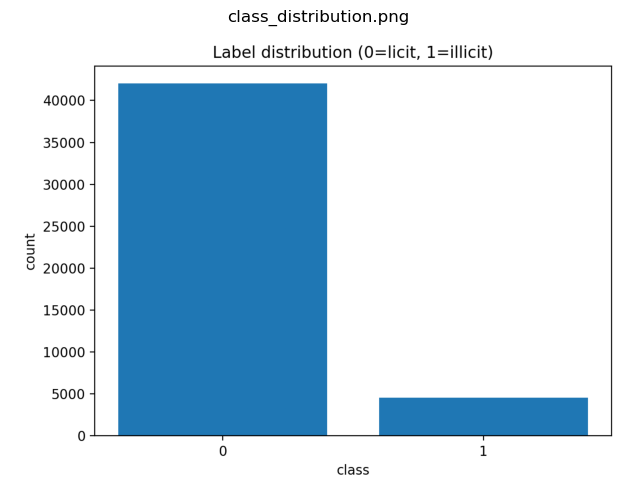

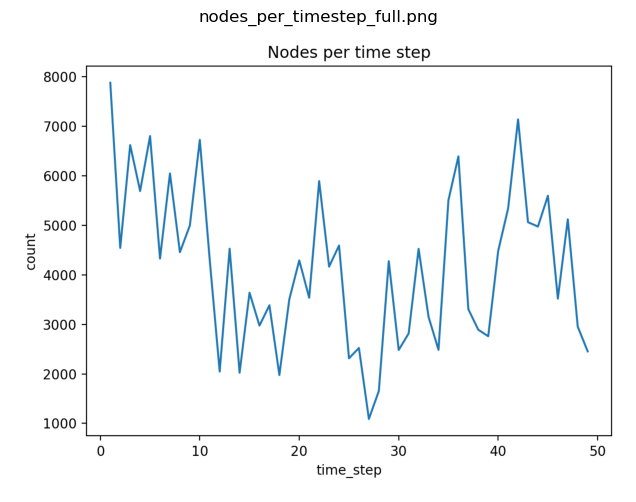

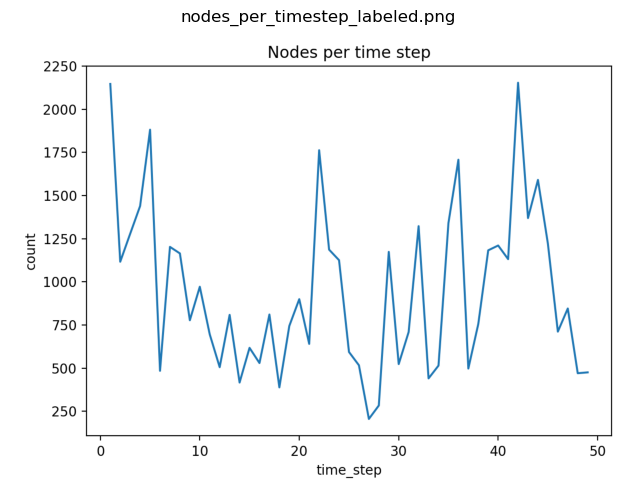

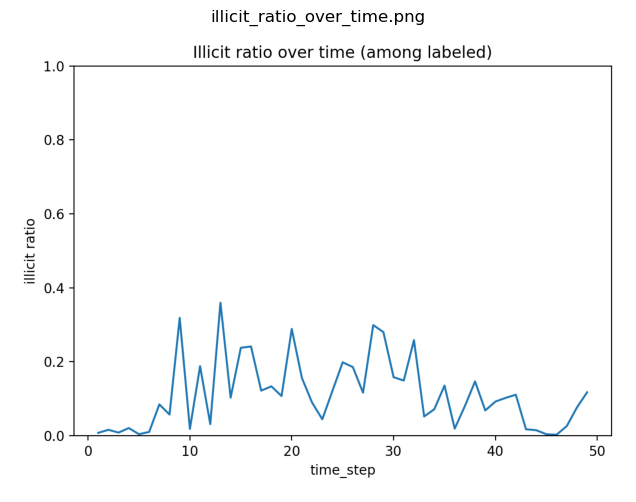

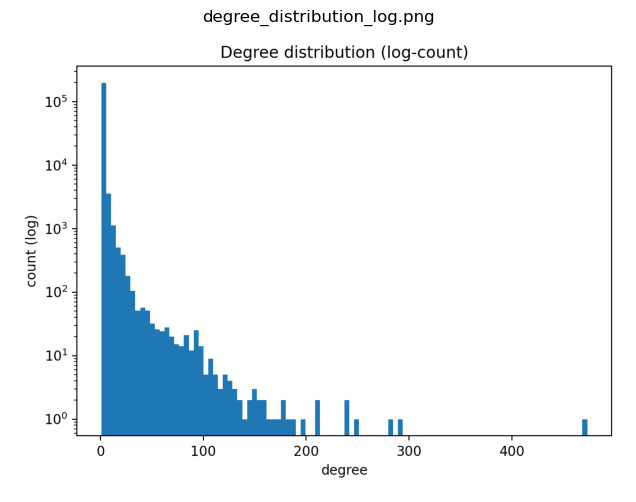

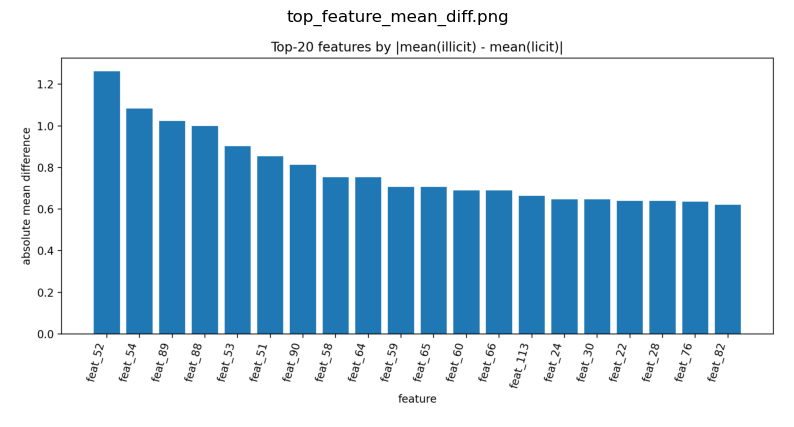

In [7]:

# Display key Phase 02 plots
eda_dir = VIZ / "phase02_eda"
list_dir(eda_dir, "*.png")

# Recommended sequence to show during presentation
for name in [
    "class_distribution.png",
    "nodes_per_timestep_full.png",
    "nodes_per_timestep_labeled.png",
    "illicit_ratio_over_time.png",
    "degree_distribution_log.png",
    "top_feature_mean_diff.png",
]:
    show_image(eda_dir / name, title=name)


## 4b) Phase 02b — Normalization visualization (if included)

**Goal:** sanity-check how feature normalization changes distributions and geometry (used later in LR and GNN training).

Artifacts are under `results/visualizations/normalizedData/`:
- Feature histograms before/after normalization
- PCA projection before/after normalization
- Per-feature mean/std summary (`normalized_stats_AF.json`)

**Important leakage rule (applied later):** normalization statistics must be computed from **training-only** data (or training-labeled nodes for GNNs), then applied to validation/test/all nodes.


results/visualizations/normalizedData/AF_means_hist.png
results/visualizations/normalizedData/AF_stds_hist.png
results/visualizations/normalizedData/AF_train_feature_hist_post.png
results/visualizations/normalizedData/AF_train_feature_hist_pre.png
results/visualizations/normalizedData/AF_train_pca_post_norm.png
results/visualizations/normalizedData/AF_train_pca_pre_norm.png


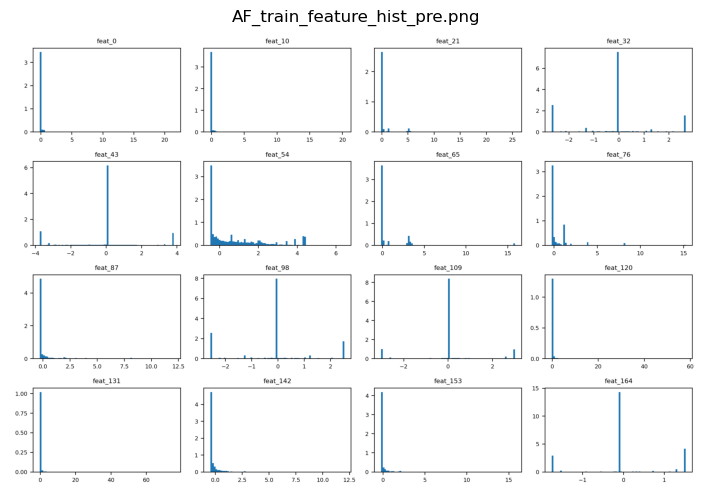

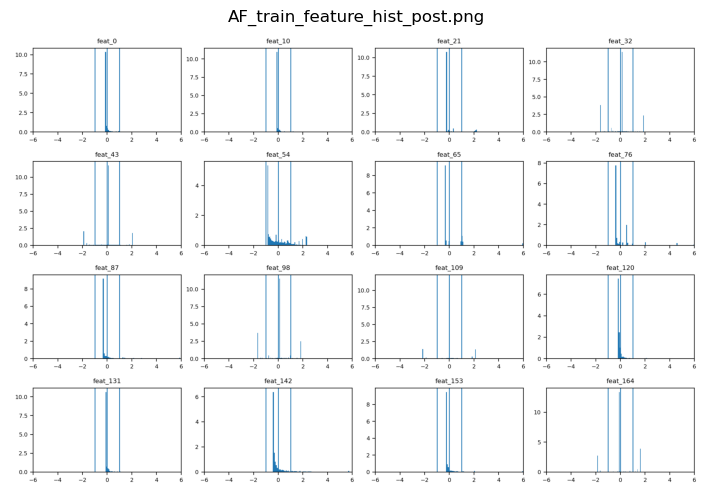

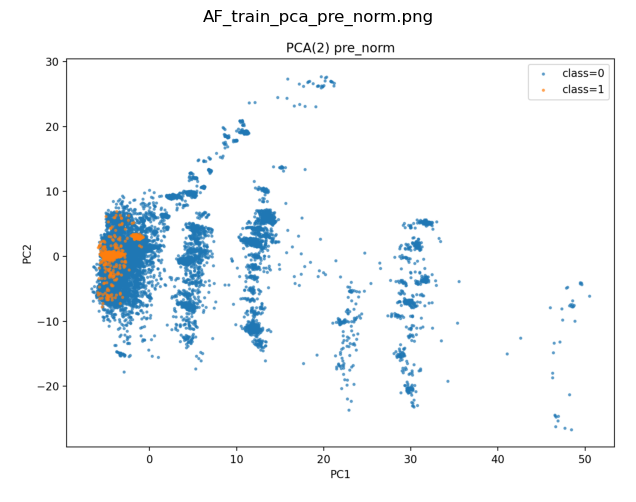

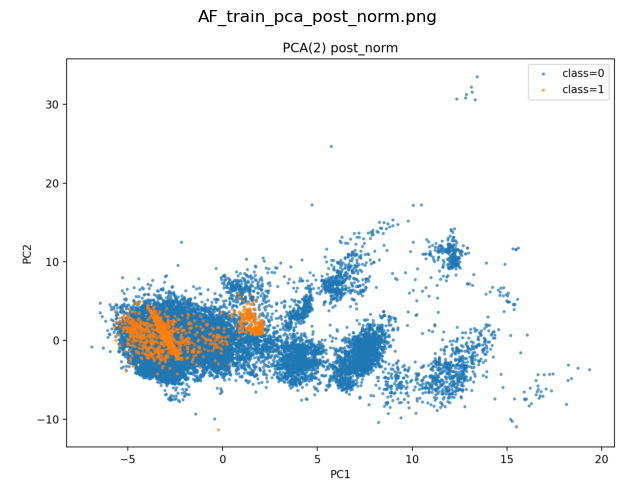

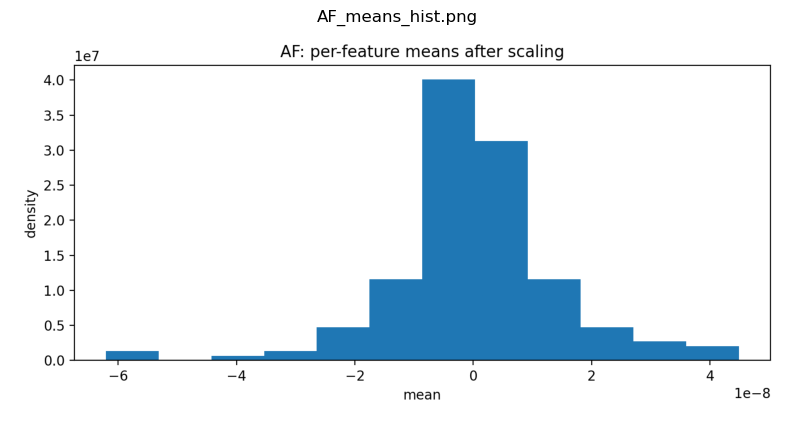

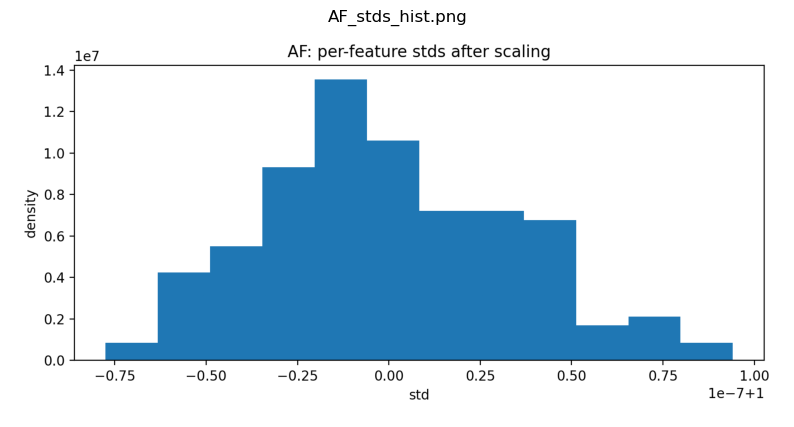

In [8]:

norm_dir = VIZ / "normalizedData"
list_dir(norm_dir, "*.png")

for name in [
    "AF_train_feature_hist_pre.png",
    "AF_train_feature_hist_post.png",
    "AF_train_pca_pre_norm.png",
    "AF_train_pca_post_norm.png",
    "AF_means_hist.png",
    "AF_stds_hist.png",
]:
    show_image(norm_dir / name, title=name)


## 5) Phase 03 — Model selection (baselines vs GNN)

**Goal:** establish credible baselines and compare feature sets and modeling families under a leakage-safe temporal protocol.

### Experimental protocol
- **Temporal split (primary):** train on early time steps, test on later time steps.
  - Tabular: train steps **1..34**, test steps **35..49**.
  - GNN: train-only **1..31**, validation **32..34**, test **35..49**.
- **Target metric:** illicit-class precision/recall/F1 (positive class = illicit).
- **Class imbalance:** class weights computed from training-labeled nodes.
- **Leakage avoidance:**
  - forward-chaining CV for tabular hyperparameter search
  - train-only normalization for LR and GNN

### Models evaluated
- **Tabular baselines:** Logistic Regression (LR) and Random Forest (RF) on:
  - AF = all features
  - LF = local features
- **Graph baselines (AF):** GCN and SkipGCN trained on the full graph (unlabeled nodes provide message-passing context; loss/metrics use labeled nodes only).
- **Embedding augmentation:** RF trained on `features ⊕ GNN embeddings` to test whether graph representations add signal beyond engineered features.

### Key Phase 03 results (model selection)
- Best illicit-F1: **RF (AF)** ≈ **0.80** (strong precision + recall).
- LR achieves high recall but poor precision (many false positives).
- GNN baselines reach moderate illicit-F1 (~0.51–0.52) on the test window under this protocol.
- Embedding augmentation yields extremely high precision but does not surpass RF(AF) in illicit-F1.


In [9]:
# =========================
# Results leaderboard (single table)
# =========================
import pandas as pd
from IPython.display import display

# Load saved Phase 03 metrics
baselines_AF = read_json(METRICS / "baselines_AF.json")
baselines_LF = read_json(METRICS / "baselines_LF.json")
gnn_AF = read_json(METRICS / "gnn_AF.json")

def _cm_to_counts(cm):
    # cm = [[TN, FP],[FN, TP]]
    tn, fp = cm[0]
    fn, tp = cm[1]
    return {"TN": tn, "FP": fp, "FN": fn, "TP": tp}

def rows_from_baselines(b: dict, fallback_fm: str):
    rows = []
    fm = b.get("feature_mode", fallback_fm)
    for model_key, pretty in [("logreg", "LR"), ("random_forest", "RF")]:
        if model_key not in b:
            continue
        m = b[model_key]
        r = {
            "group": "tabular",
            "feature_mode": fm,
            "model": pretty,
            "precision_illicit": m.get("precision_illicit"),
            "recall_illicit": m.get("recall_illicit"),
            "f1_illicit": m.get("f1_illicit"),
            "f1_micro": m.get("f1_micro"),
        }
        if "cm" in m:
            r.update(_cm_to_counts(m["cm"]))
        rows.append(r)
    return rows

def rows_from_gnn(g: dict, fallback_fm: str):
    rows = []
    fm = g.get("feature_mode", fallback_fm)
    model_map = [("gcn", "GCN"), ("skip_gcn", "SkipGCN"), ("rf_on_gnn_embeddings", "RF-on-Embeddings")]
    for k, pretty in model_map:
        if k not in g:
            continue
        block = g[k]
        m = block.get("test_metrics", block)  # sometimes metrics are stored directly
        r = {
            "group": "gnn",
            "feature_mode": fm,
            "model": pretty,
            "precision_illicit": m.get("precision_illicit"),
            "recall_illicit": m.get("recall_illicit"),
            "f1_illicit": m.get("f1_illicit"),
            "f1_micro": m.get("f1_micro"),
        }
        if "cm" in m:
            r.update(_cm_to_counts(m["cm"]))
        rows.append(r)
    return rows

# Build leaderboard
rows = []
rows += rows_from_baselines(baselines_AF, "AF")
rows += rows_from_baselines(baselines_LF, "LF")
rows += rows_from_gnn(gnn_AF, "AF")

df_models = pd.DataFrame(rows)

# Keep only relevant columns (in order)
cols = ["group","feature_mode","model","precision_illicit","recall_illicit","f1_illicit","f1_micro","TN","FP","FN","TP"]
df_models = df_models[[c for c in cols if c in df_models.columns]]

# Sort by key metric (desc), then by model name for stable ordering
sort_cols = ["f1_illicit"] if "f1_illicit" in df_models.columns else ["f1_micro"]
df_models = df_models.sort_values(sort_cols + ["group","feature_mode","model"], ascending=[False, True, True, True]).reset_index(drop=True)

display(
    df_models.style.format({
        "precision_illicit": "{:.3f}",
        "recall_illicit": "{:.3f}",
        "f1_illicit": "{:.3f}",
        "f1_micro": "{:.3f}",
    })
)


,group,feature_mode,model,precision_illicit,recall_illicit,f1_illicit,f1_micro,TN,FP,FN,TP
0,tabular,AF,RF,0.899,0.725,0.803,0.977,15499,88,298,785
1,tabular,LF,RF,0.888,0.702,0.784,0.975,15491,96,323,760
2,gnn,AF,RF-on-Embeddings,0.993,0.645,0.782,0.977,15582,5,385,698
3,gnn,AF,SkipGCN,0.473,0.579,0.521,0.931,14888,699,456,627
4,gnn,AF,GCN,0.507,0.512,0.509,0.936,15048,539,529,554
5,tabular,AF,LR,0.219,0.824,0.346,0.798,12410,3177,191,892
6,tabular,LF,LR,0.191,0.833,0.311,0.760,11771,3816,181,902


In [10]:
# =========================
# Experimental context (class weights + graph / split sizes)
# =========================
import pandas as pd
from IPython.display import display

# Class weights (tabular)
# In your JSON they appear as a dict like {"0": w0, "1": w1} or {0: w0, 1: w1}
def class_weights_table(b: dict, fallback_fm: str):
    fm = b.get("feature_mode", fallback_fm)
    cw = b.get("class_weights", {})
    # normalize keys to strings for display
    row = {"feature_mode": fm}
    for k, v in cw.items():
        row[str(k)] = v
    return row

cw = pd.DataFrame([
    class_weights_table(baselines_AF, "AF"),
    class_weights_table(baselines_LF, "LF"),
])
display(cw)

# Graph + split summary (gnn)
g = gnn_AF
graph_row = (g.get("graph", {}) or {}).copy()
steps_row = {
    "train_steps": f"{min(g['train_steps'])}..{max(g['train_steps'])} (n={len(g['train_steps'])})" if "train_steps" in g else None,
    "val_steps":   f"{min(g['val_steps'])}..{max(g['val_steps'])} (n={len(g['val_steps'])})" if "val_steps" in g else None,
    "test_steps":  f"{min(g['test_steps'])}..{max(g['test_steps'])} (n={len(g['test_steps'])})" if "test_steps" in g else None,
    "device": g.get("device"),
}
context = pd.DataFrame([{**graph_row, **steps_row}])
display(context)


,feature_mode,0,1
0,AF,0.565489,4.317447
1,LF,0.565489,4.317447


,num_nodes,num_edges,train_nodes_labeled,val_nodes_labeled,test_nodes_labeled,unlabeled_nodes,train_steps,val_steps,test_steps,device
0,203769,468710,27615,2279,16670,157205,1..31 (n=31),32..34 (n=3),35..49 (n=15),cuda


## 6) Phase 04 — Hyperparameter tuning + thresholding + calibration

**Goal:** produce final tuned **tabular** baselines under temporal CV, then choose an operational threshold without test leakage.

### What Phase 04 adds on top of Phase 03
- **Leakage-safe hyperparameter optimization:** forward-chaining CV within the training time window.
- **Threshold tuning:** choose a decision threshold `t` for `p(illicit)` using a **tail slice inside training** (not the test set), optimizing illicit-F1.
- **Diagnostics:** PR curves, threshold sweeps, calibration curves, confusion matrices.

### Why threshold tuning is necessary
Under severe class imbalance, a default `0.5` threshold is rarely optimal.  
Phase 04 explicitly selects thresholds aligned with the project’s target metric (illicit-F1) using only past data.


results/visualizations/phase04/calib_lr_AF_cuml.png
results/visualizations/phase04/calib_lr_LF_cuml.png
results/visualizations/phase04/calib_rf_AF_cuml.png
results/visualizations/phase04/calib_rf_LF_cuml.png
results/visualizations/phase04/cm_lr_AF_cuml.png
results/visualizations/phase04/cm_lr_AF_cuml_norm.png
results/visualizations/phase04/cm_lr_LF_cuml.png
results/visualizations/phase04/cm_lr_LF_cuml_norm.png
results/visualizations/phase04/cm_rf_AF_cuml.png
results/visualizations/phase04/cm_rf_AF_cuml_norm.png
results/visualizations/phase04/cm_rf_LF_cuml.png
results/visualizations/phase04/cm_rf_LF_cuml_norm.png
results/visualizations/phase04/pr_lr_AF_cuml.png
results/visualizations/phase04/pr_lr_LF_cuml.png
results/visualizations/phase04/pr_rf_AF_cuml.png
results/visualizations/phase04/pr_rf_LF_cuml.png
results/visualizations/phase04/thr_sweep_lr_AF_cuml.png
results/visualizations/phase04/thr_sweep_lr_LF_cuml.png
results/visualizations/phase04/thr_sweep_rf_AF_cuml.png
results/visualiz

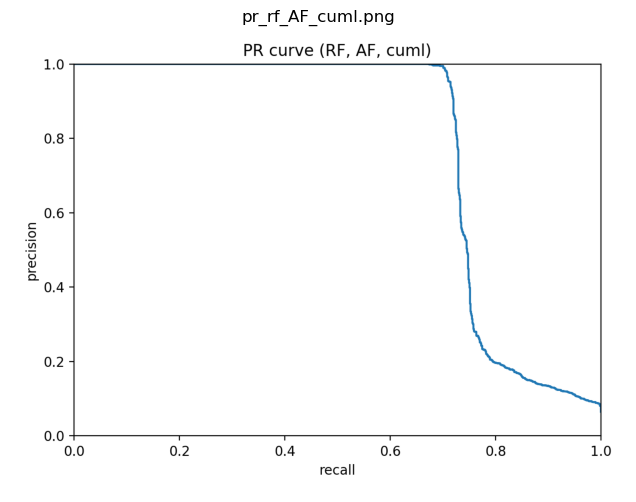

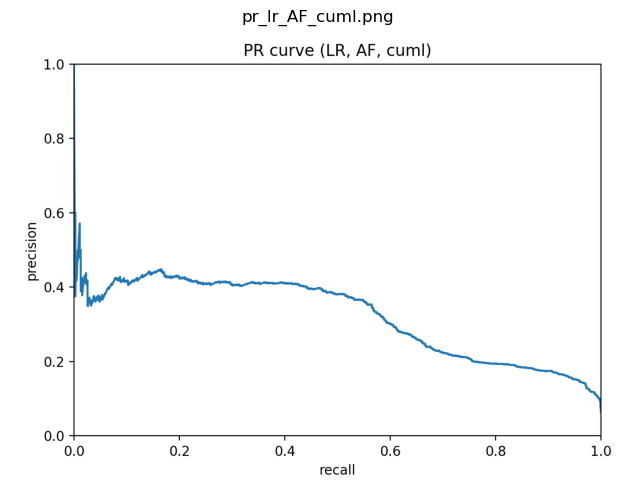

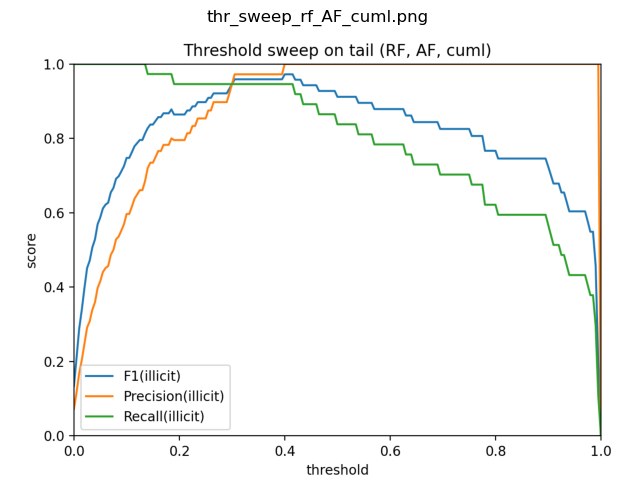

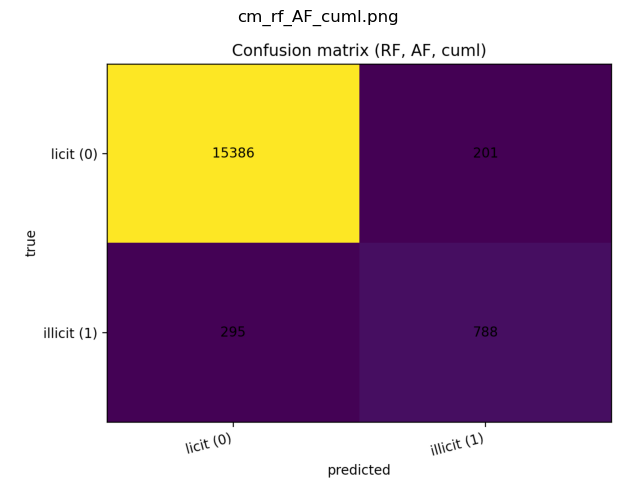

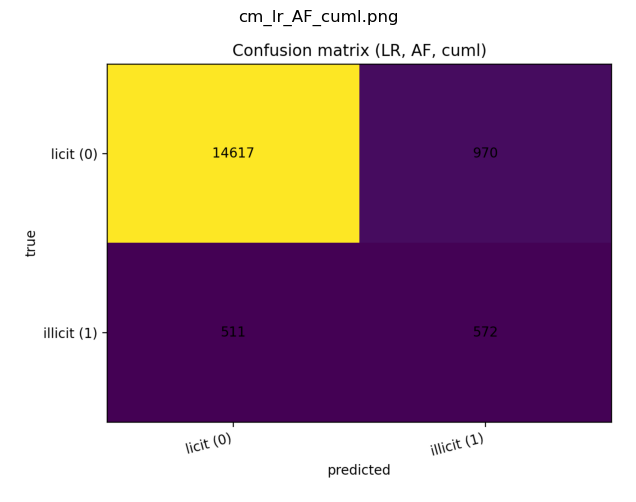

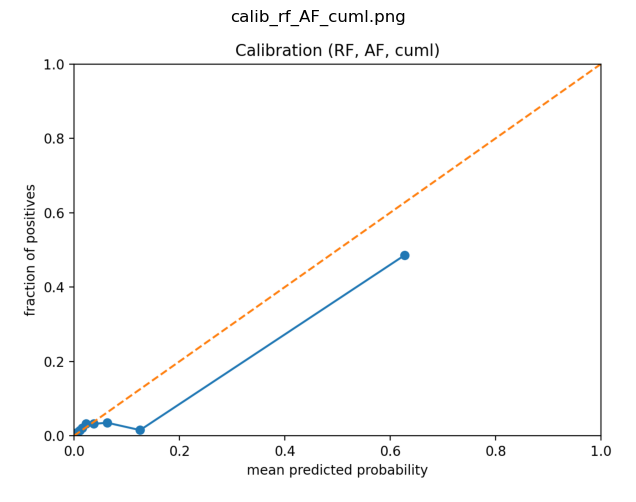

In [11]:

phase04_dir = VIZ / "phase04"
list_dir(phase04_dir, "*.png")

# Recommended minimal set to show during grading
for name in [
    "pr_rf_AF_cuml.png",
    "pr_lr_AF_cuml.png",
    "thr_sweep_rf_AF_cuml.png",
    "cm_rf_AF_cuml.png",
    "cm_lr_AF_cuml.png",
    "calib_rf_AF_cuml.png",
]:
    show_image(phase04_dir / name, title=name)


In [12]:
#Phase 04 tuning summary table (reads threshold float correctly)

import json
import pandas as pd
from pathlib import Path
from IPython.display import display

def fmt3(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""
    try:
        return f"{float(x):.3f}"
    except Exception:
        return str(x)

def read_json(path: Path):
    path = Path(path)
    if not path.exists():
        return None
    return json.loads(path.read_text(encoding="utf-8"))

def summarize_phase04_mode(tuning: dict, mode: str):
    """
    Schema:
      tuning keys: feature_mode, tabular_backend, split, threshold_tune_tail_steps, class_weights_train, cv, logreg, random_forest
      tuning[model] keys: best_hparams, best_cv_f1_illicit, threshold (float), tail_f1_illicit, test, trials_top10
    """
    if not isinstance(tuning, dict):
        return []

    out = []
    for key, label in [("logreg", "LR"), ("random_forest", "RF")]:
        block = tuning.get(key)
        if not isinstance(block, dict):
            continue

        test = block.get("test") if isinstance(block.get("test"), dict) else {}
        thr_val = block.get("threshold")

        out.append({
            "mode": mode,
            "model": label,
            "backend": tuning.get("tabular_backend"),
            "best_cv_f1_illicit": block.get("best_cv_f1_illicit"),
            "tuned_threshold": thr_val,
            "tail_f1_illicit": block.get("tail_f1_illicit"),
            "test_precision_illicit": (test or {}).get("precision_illicit"),
            "test_recall_illicit": (test or {}).get("recall_illicit"),
            "test_f1_illicit": (test or {}).get("f1_illicit"),
            "test_f1_micro": (test or {}).get("f1_micro"),
        })
    return out

# --- load files ---
af_path  = Path(METRICS) / "phase04_tuning_AF_cuml.json"
lf_path  = Path(METRICS) / "phase04_tuning_LF_cuml.json"
idx_path = Path(METRICS) / "phase04_tuning_index_cuml.json"

tuning_AF  = read_json(af_path)
tuning_LF  = read_json(lf_path)
tuning_idx = read_json(idx_path)

# --- prefer index if present; your index uses "modes" ---
rows = []
if isinstance(tuning_idx, dict) and isinstance(tuning_idx.get("modes"), dict):
    modes = tuning_idx["modes"]
    if isinstance(modes.get("AF"), dict):
        rows += summarize_phase04_mode(modes["AF"], "AF")
    if isinstance(modes.get("LF"), dict):
        rows += summarize_phase04_mode(modes["LF"], "LF")

# --- fallback to standalone files ---
if not rows:
    if isinstance(tuning_AF, dict):
        rows += summarize_phase04_mode(tuning_AF, "AF")
    if isinstance(tuning_LF, dict):
        rows += summarize_phase04_mode(tuning_LF, "LF")

if not rows:
    raise RuntimeError("Could not parse Phase 04 tuning JSONs.")
else:
    df_tuning = pd.DataFrame(rows).sort_values(["mode", "model"]).reset_index(drop=True)

display(
    df_tuning.style.format({
        "best_cv_f1_illicit": fmt3,
        "tuned_threshold": fmt3,
        "tail_f1_illicit": fmt3,
        "test_precision_illicit": fmt3,
        "test_recall_illicit": fmt3,
        "test_f1_illicit": fmt3,
        "test_f1_micro": fmt3,
    })
)


,mode,model,backend,best_cv_f1_illicit,tuned_threshold,tail_f1_illicit,test_precision_illicit,test_recall_illicit,test_f1_illicit,test_f1_micro
0,AF,LR,cuml,0.714,0.947,0.667,0.371,0.528,0.436,0.911
1,AF,RF,cuml,0.933,0.413,0.972,0.797,0.728,0.761,0.970
2,LF,LR,cuml,0.706,0.797,0.727,0.390,0.729,0.508,0.908
3,LF,RF,cuml,0.937,0.402,0.909,0.765,0.721,0.742,0.967


In [13]:
# Compact Phase 04 split / class-weights / CV summaries (handles int val_steps & int folds)

from __future__ import annotations
from typing import Any, Dict, Mapping, Optional, List
import pandas as pd
from IPython.display import display

def _as_list(x: Any) -> List[Any]:
    if x is None:
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    return [x]  # scalar -> singleton list

def _range_str(x: Any) -> Optional[str]:
    xs = _as_list(x)
    if not xs:
        return None
    try:
        return f"{min(xs)}..{max(xs)} (n={len(xs)})"
    except Exception:
        return f"n={len(xs)}"

def compact_split(tuning: Optional[Mapping[str, Any]], mode: str) -> Optional[Dict[str, Any]]:
    if not isinstance(tuning, Mapping):
        return None
    split = tuning.get("split")
    split = split if isinstance(split, Mapping) else {}
    return {
        "mode": mode,
        "backend": tuning.get("tabular_backend"),
        "threshold_tune_tail_steps": _range_str(tuning.get("threshold_tune_tail_steps")),
        "train_steps": _range_str(split.get("train_steps")),
        "test_steps": _range_str(split.get("test_steps")),
    }

def compact_class_weights(tuning: Optional[Mapping[str, Any]], mode: str) -> Optional[Dict[str, Any]]:
    if not isinstance(tuning, Mapping):
        return None
    cw = tuning.get("class_weights_train")
    cw = cw if isinstance(cw, Mapping) else {}
    return {"mode": mode, "w0": cw.get("0"), "w1": cw.get("1")}

def compact_cv(tuning: Optional[Mapping[str, Any]], mode: str) -> Optional[Dict[str, Any]]:
    if not isinstance(tuning, Mapping):
        return None
    cv = tuning.get("cv")
    cv = cv if isinstance(cv, Mapping) else {}

    # your JSON: val_steps is int, folds is int (count)
    val_steps = cv.get("val_steps")
    folds = cv.get("folds")

    folds_count = folds if isinstance(folds, int) else (len(folds) if isinstance(folds, (list, tuple, dict)) else None)

    return {
        "mode": mode,
        "n_splits": cv.get("n_splits"),
        "val_steps": _range_str(val_steps),
        "folds": folds_count,
    }

rows_split = [r for r in (compact_split(tuning_AF, "AF"), compact_split(tuning_LF, "LF")) if r]
rows_cw    = [r for r in (compact_class_weights(tuning_AF, "AF"), compact_class_weights(tuning_LF, "LF")) if r]
rows_cv    = [r for r in (compact_cv(tuning_AF, "AF"), compact_cv(tuning_LF, "LF")) if r]

display(pd.DataFrame(rows_split))
display(pd.DataFrame(rows_cw))
display(pd.DataFrame(rows_cv))


,mode,backend,threshold_tune_tail_steps,train_steps,test_steps
0,AF,cuml,34..34 (n=1),1..34 (n=34),35..49 (n=15)
1,LF,cuml,34..34 (n=1),1..34 (n=34),35..49 (n=15)


,mode,w0,w1
0,AF,0.565489,4.317447
1,LF,0.565489,4.317447


,mode,n_splits,val_steps,folds
0,AF,5,1..1 (n=1),5
1,LF,5,1..1 (n=1),5


## 7) Phase 05 — Final evaluation + inference outputs

**Goal:** reproduce final test-set metrics for:
- tuned tabular models from Phase 04 (AF + LF), using saved scalers and tuned thresholds,
- GNN checkpoints from Phase 03 (AF), by rebuilding the graph identically and loading best hyperparameters to match checkpoint shapes.

### Outputs
- `results/metrics/phase05_eval_report.json` — single JSON source of truth (metrics + paths).
- `results/predictions/*.parquet` — per-model prediction exports (`txId, time_step, class, p_illicit, y_pred`).
- `results/visualizations/phase05/phase05_final_f1_summary.png` — final illicit-F1 comparison bar plot.

### Final result (this run)
Best illicit-F1 on the held-out test window: **Random Forest (AF) with tuned threshold**.


In [14]:
# Phase 05: extract a compact evaluation table (metrics + thresholds)
phase05 = read_json(METRICS / "phase05_eval_report.json")


rows = []

def _get(d, *keys, default=None):
    cur = d
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur

if phase05:
    # Tabular tuned models (Phase 04 artifacts evaluated in Phase 05)
    te = phase05.get("phase04_tabular_eval", {})
    for mode in ("AF","LF"):
        if mode in te:
            for model_key, model_label in (("lr","LR"), ("rf","RF")):
                md = te[mode].get(model_key)
                if not md:
                    continue
                metrics = md.get("metrics", {})
                thr = md.get("threshold", md.get("best_threshold", None))
                rows.append({
                    "model": f"{model_label}_{mode}",
                    "threshold": thr,
                    "precision_illicit": metrics.get("precision_illicit"),
                    "recall_illicit": metrics.get("recall_illicit"),
                    "f1_illicit": metrics.get("f1_illicit"),
                    "f1_micro": metrics.get("f1_micro"),
                })
    # GNN checkpoints
    for key, label in (("gcn_AF","GCN_AF"), ("skip_gcn_AF","SkipGCN_AF")):
        md = phase05.get(key)
        if md and "metrics" in md:
            m = md["metrics"]
            rows.append({
                "model": label,
                "threshold": None,
                "precision_illicit": m.get("precision_illicit"),
                "recall_illicit": m.get("recall_illicit"),
                "f1_illicit": m.get("f1_illicit"),
                "f1_micro": m.get("f1_micro"),
            })


df_phase05 = pd.DataFrame(rows).sort_values("f1_illicit", ascending=False)
df_phase05


,model,threshold,precision_illicit,recall_illicit,f1_illicit,f1_micro
1,RF_AF,0.413269,0.796764,0.727608,0.760618,0.970246
3,RF_LF,0.401667,0.764936,0.721145,0.742395,0.967487
5,SkipGCN_AF,NaN,0.472851,0.578947,0.520548,0.930714
4,GCN_AF,NaN,0.506862,0.511542,0.509191,0.935933
2,LR_LF,0.797274,0.390208,0.728532,0.508213,0.908398
0,LR_AF,0.947084,0.370947,0.528163,0.435810,0.911158


results/visualizations/phase05/phase05_final_f1_summary.png


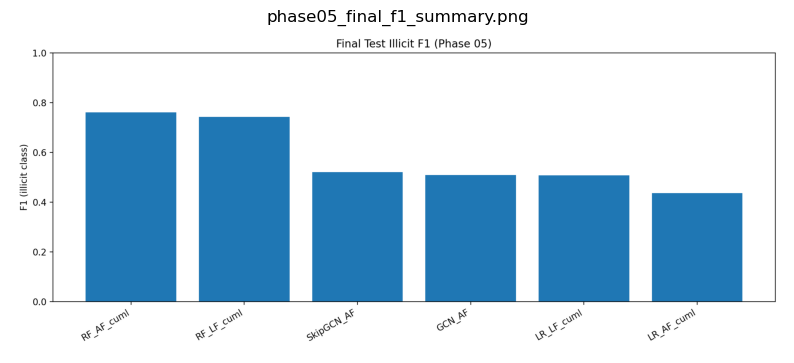

In [15]:

phase05_dir = VIZ / "phase05"
list_dir(phase05_dir, "*.png")
show_image(phase05_dir / "phase05_final_f1_summary.png", title="phase05_final_f1_summary.png")


In [16]:
# Show a RANDOM sample of prediction rows (with optional balancing so it's not all TN)
# - If y_true / y_pred columns exist, it will try to show a mix of TP/FP/FN/TN.
# - Falls back to uniform random sampling if columns are not found.

import numpy as np
import pandas as pd
from IPython.display import display

pred_files = list_dir(PRED, "*.parquet")

preferred_order = [
    "phase05_tabular_rf_AF",
    "phase05_tabular_rf_LF",
    "phase05_tabular_lr_AF",
    "phase05_tabular_lr_LF",
    "phase05_gnn_skip_gcn_AF",
    "phase05_gnn_gcn_AF",
]

chosen = None
for pref in preferred_order:
    for p in pred_files:
        if pref in p.name:
            chosen = p
            break
    if chosen:
        break
if chosen is None and pred_files:
    chosen = pred_files[0]

# ---- sampling helpers ----
def _first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def sample_predictions(df: pd.DataFrame, n: int = 12, seed=None, balance_cm: bool = True) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    if len(df) == 0:
        return df

    cols = list(df.columns)
    y_true_col = _first_existing(cols, ["y_true", "label", "target", "true", "gt", "y"])
    y_pred_col = _first_existing(cols, ["y_pred", "pred", "pred_label", "prediction", "yhat"])
    score_col  = _first_existing(cols, ["y_score", "proba", "p_illicit", "prob", "score", "logit"])

    # If we can, create confusion-type strata and sample across them
    if balance_cm and y_true_col and y_pred_col:
        y_true = df[y_true_col]
        y_pred = df[y_pred_col]

        # try to coerce to 0/1
        def to01(s):
            if pd.api.types.is_bool_dtype(s):
                return s.astype(int)
            if pd.api.types.is_numeric_dtype(s):
                return (s.astype(float) > 0.5).astype(int)
            # string labels: map common tokens
            m = s.astype(str).str.lower().map({"0":0,"1":1,"licit":0,"illicit":1,"false":0,"true":1})
            if m.notna().any():
                return m.fillna(0).astype(int)
            return pd.to_numeric(s, errors="coerce").fillna(0).astype(int)

        yt = to01(y_true)
        yp = to01(y_pred)

        strata = {
            "TP": df[(yt == 1) & (yp == 1)],
            "FP": df[(yt == 0) & (yp == 1)],
            "FN": df[(yt == 1) & (yp == 0)],
            "TN": df[(yt == 0) & (yp == 0)],
        }

        # allocate roughly equally, but don't exceed what's available
        base = n // 4
        rem = n % 4
        order = ["TP", "FP", "FN", "TN"]
        alloc = {k: base for k in order}
        for k in order[:rem]:
            alloc[k] += 1

        parts = []
        for k in order:
            sdf = strata[k]
            take = min(alloc[k], len(sdf))
            if take > 0:
                idx = rng.choice(sdf.index.to_numpy(), size=take, replace=False)
                parts.append(df.loc[idx].assign(_bucket=k))
        if parts:
            out = pd.concat(parts, axis=0)
            out = out.sample(frac=1.0, random_state=int(rng.integers(0, 2**32 - 1)))  # shuffle
            # useful ordering: show score if exists
            if score_col and score_col in out.columns:
                out = out.sort_values(by=score_col, ascending=False)
            return out.head(n)

    # fallback: uniform random sample
    idx = rng.choice(df.index.to_numpy(), size=min(n, len(df)), replace=False)
    out = df.loc[idx]
    if score_col and score_col in out.columns:
        out = out.sort_values(by=score_col, ascending=False)
    return out

if chosen is not None:
    print("Showing:", chosen.relative_to(ROOT))
    df_pred = pd.read_parquet(chosen)

    # Change these knobs if you want:
    N_SHOW = 12
    BALANCE_CM = True          # set False for pure random
    SEED = None                # set e.g. 42 for reproducible sampling

    sample = sample_predictions(df_pred, n=N_SHOW, seed=SEED, balance_cm=BALANCE_CM)
    display(sample)
    print("rows:", len(df_pred), "cols:", df_pred.shape[1])
else:
    print("[missing] no prediction parquet files found under results/predictions/")


results/predictions/phase05_gnn_gcn_AF.parquet
results/predictions/phase05_gnn_skip_gcn_AF.parquet
results/predictions/phase05_tabular_lr_AF_cuml.parquet
results/predictions/phase05_tabular_lr_LF_cuml.parquet
results/predictions/phase05_tabular_rf_AF_cuml.parquet
results/predictions/phase05_tabular_rf_LF_cuml.parquet
Showing: results/predictions/phase05_tabular_rf_AF_cuml.parquet


,txId,time_step,class,p_illicit,y_pred
8784,96939427,40,1,0.999907,1
5376,71455569,42,0,0.516901,1
10020,105596633,44,0,0.479883,1
13836,158269776,49,0,0.108369,0
12945,155533543,45,0,0.100874,0
15969,218011208,47,0,0.046851,0
4523,67603027,35,0,0.040246,0
15801,203514078,36,0,0.017796,0
2429,28903935,37,1,0.017130,0
10356,105858525,44,0,0.010242,0


rows: 16670 cols: 5


## 8) the differance between the paper scores and our experiments scores

| Model    | Paper F1 | Our F1 | Δ (ours − paper) |
| -------- | -------: | -----: | ---------------: |
| LR (AF)  |    0.481 |  0.436 |           −0.045 |
| LR (LF)  |    0.457 |  0.508 |           +0.051 |
| RF (AF)  |    0.788 |  0.761 |           −0.027 |
| RF (LF)  |    0.694 |  0.742 |           +0.048 |
| GCN      |    0.628 |  0.509 |           −0.119 |
| Skip-GCN |    0.705 |  0.521 |           −0.184 |


## 9) Conclusions

- The project implements an **end-to-end**, reproducible AML pipeline on Elliptic: preprocessing → EDA → baselines → GNNs → tuning → final evaluation.
- **Temporal evaluation** (train on earlier `time_step`, test on later) is enforced throughout to prevent leakage and mimic deployment.
- The dataset is **highly imbalanced** (illicit is the minority), so reporting focuses on **illicit precision/recall/F1**, not only accuracy/micro-F1.
- **Tabular models on engineered features dominate** in illicit-F1 under this protocol; **AF** consistently outperforms **LF**.
- **GNN baselines** (GCN / SkipGCN) learn usable signal but generalize to the test window with **moderate illicit-F1**, below tuned RF.
- **Threshold tuning** (Phase 04) is required for a meaningful operating point under imbalance; Phase 05 evaluates models using these saved thresholds.
- Prediction exports (Phase 05) enable auditability: the grader can inspect per-sample probabilities, threshold decisions, and errors by time step.
- Main limitations: (i) limited GNN tuning budget/architecture depth, (ii) temporal distribution shift, (iii) unlabeled-node supervision sparsity.



## Appendix A — How to reproduce end-to-end (commands)

From repository root.

### Option 1: run phase-by-phase (recommended for reproducibility)
```bash
# Phase 01
python -m src.main --phase 1

# Phase 02 (EDA)
python -m src.main --phase 2

# Phase 02b (normalization viz, optional)
python -m src.main --phase 2b

# Phase 03 (model selection)
python -m src.main --phase 3 --device cuda --tabular-backend cuml

# Phase 04 (tabular tuning + thresholding)
python -m src.main --phase 4 --device cuda --tabular-backend cuml

# Phase 05 (final eval + prediction export)
python -m src.main --phase 5 --device cuda
```

### Key outputs to check
- `results/metrics/phase01_data_summary.json`
- `results/metrics/phase02_eda_summary.json`
- `results/metrics/baselines_*.json`, `results/metrics/gnn_*.json`
- `results/metrics/phase04_tuning_index_*.json`
- `results/metrics/phase05_eval_report.json`
